<a href="https://colab.research.google.com/github/pikey-msc/DeepLearn/blob/master/notebooks/Predicci%C3%B3n_de_datos_de_acciones_con_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

## Resumen

Haremos lo siguiente

1. Descargaremos datos financieros de alto nivel para obtener el precio de las acciones de ciertas compañías
2.  Analizar (alto nivel) tendencias de esas acciones; y, To review high-level trends for those stocks; and,
3. Crear un modelo predictivo LSTM usando dichos datos


## Notas en la información a analizar

Se obtendrá información de Yahoo Finance:

- Opening Share Price at the start of each trading day
- The Closing Share Price at the end of each trading day
- The volume of shares traded on each given day
- The Highest share price on each given day
- The Lowest share price on each given day
- The Adjusted Closing Price for each share on each given day..



# Resultados

Obtendremos los siguientes resultados:

1. **Determinaremos qué acción se comporta mejor:**
  - La gráfica con el valor absolutos de las acciones muestra que el S&P500 es el bueno
  - Sin embargo, la gráfica de precios estadarizados (contra 2017) muestra que los valores al cuadrado mejoran su rendimiento
  - Por ejemplo el precio de la parte al cuadrado incrementado de APPL por el factor 5 desde 018, que comparado con el de Amazon de 2.5 es considerablemente mayor
2. **Retorno de inversión:**
  - Si invirtiéramos USD10,000 en cada una de las acciones en Enero 2017 tendríamos USD 179,900 para 29 Noviembre 2019.
  
3. **Acciones más transaccionadas:**
  - Se muestra que el S&P500 es la más transaccionada (usando la mediana del volumen como medida) mientras que Google's es la menos transaccionada.
4. **Perfoemance vs. S&P500:**
  - Tesla es la menos correlacionada con el the S&P500, debido a cambios erráticos del precio desde 2017.
  - Google es la más correlacionada con  R2 de 0.95
5. **Prediciendo el precio de cierre Closing Price:**
  - Un modelo LSTM se desarrolló para pronosticar e precio de cierre de un día 
  - El modelo es ilustrativo y basado en variables que incluyen:
    - Opening Price
    - Highest Share Price
    - Lowest Share Price
    - Volumes Traded
  - RMSE de 0.01779
  - Los errores de predicción en los datos de prueba se muestran
  


## Leer datos de Yahoo Finance

In [107]:
import pandas as pd
import requests
from datetime import datetime
import pandas_datareader.data as web
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import itertools
from scipy import stats

%matplotlib inline
sns.set()
matplotlib.rcParams['figure.figsize'] = (18.0, 9.0)
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

data_source = 'yahoo'
start = "2017-01-01" #@param {type:"string"}
end = "2020-09-22" #@param {type:"string"}

tickers = ['AAPL', 'FB',
           'GOOG', 'AMZN',
           'SQ', 'TWTR',
           'TSLA', '^GSPC']
fail_count = 0
ok_count = 0

source_data_df = pd.DataFrame()

for ticker in tickers:
    try:
        result = web.DataReader(ticker, data_source, start, end)
        if ticker == '^GSPC':
          result['Source'] = 'S&P500'
        else:
          result['Source'] = ticker
        source_data_df = source_data_df.append(result) 
        print ("Read data for " + ticker + " " + repr(result.shape))
        ok_count += 1
    except:
        print ("Could not read data for " + ticker)
        fail_count += 1

print(str(ok_count) + " loads, " + str(fail_count) + " failures")

Read data for AAPL (937, 7)
Read data for FB (937, 7)
Read data for GOOG (937, 7)
Read data for AMZN (937, 7)
Read data for SQ (937, 7)
Read data for TWTR (937, 7)
Read data for TSLA (937, 7)
Read data for ^GSPC (937, 7)
8 loads, 0 failures


# Análisis de datos

# Análisis de cambios en pesos absolutos de precios


Revisemos que están bien los datos.

In [108]:
source_data_df[source_data_df['Source']== 'S&P500'].tail()

,High,Low,Open,Close,Volume,Adj Close,Source
Date,,,,,,,
2020-09-16,3428.919922,3384.449951,3411.229980,3385.489990,4.710030e+09,3385.489990,S&P500
2020-09-17,3375.169922,3328.820068,3346.860107,3357.010010,4.371940e+09,3357.010010,S&P500
2020-09-18,3362.270020,3292.399902,3357.379883,3319.469971,7.068700e+09,3319.469971,S&P500
2020-09-21,3285.570068,3229.100098,3285.570068,3281.060059,4.828350e+09,3281.060059,S&P500
2020-09-22,3320.310059,3270.949951,3295.750000,3315.570068,3.963300e+09,3315.570068,S&P500


In [109]:
source_data_df.reset_index(inplace=True) # Reset the index to get datatime as a column
source_data_df.describe(include='all')

,Date,High,Low,Open,Close,Volume,Adj Close,Source
count,7496,7496.000000,7496.000000,7496.000000,7496.000000,7.496000e+03,7496.000000,7496
unique,937,NaN,NaN,NaN,NaN,NaN,NaN,8
top,2019-04-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,S&P500
freq,8,NaN,NaN,NaN,NaN,NaN,NaN,937
first,2017-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-09-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,755.860266,743.102089,749.708292,749.865622,5.077010e+08,749.739234,NaN
std,NaN,995.001438,981.341587,988.575355,988.583050,1.308997e+09,988.673220,NaN
min,NaN,14.015000,13.660000,13.820000,13.810000,3.475000e+05,13.810000,NaN
25%,NaN,49.326999,47.882001,48.583749,48.559626,5.903100e+06,48.281999,NaN


Finalmente, graficamos los cambios del precio con respecto al tiempo

Text(0, 0.5, 'Closing Price [USD]')

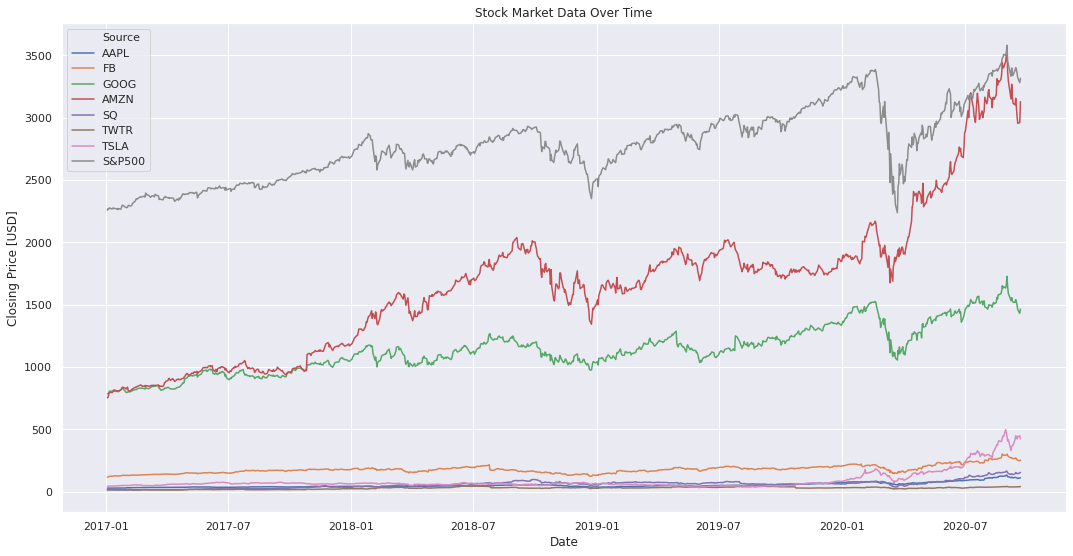

In [110]:
ax1 = sns.lineplot(x="Date",
                  y="Close",
                  hue = 'Source', data=source_data_df)
ax1.set_title('Stock Market Data Over Time')
ax1.set_ylabel('Closing Price [USD]')

## Análisis de pesos estandarizados

* Es importante notar que los datos no muestran una representación justa del cambio absoluto desde 2017
* Por eso, normalizamos los datos para reflejar los cambios en porcentaje desde 2017

In [111]:
firsts = (source_data_df.groupby(['Source']).transform('first'))
source_data_df['Standardised_Closed'] = source_data_df['Close']/firsts['Close']

Text(0, 0.5, 'Standardised Closing Price [USD]')

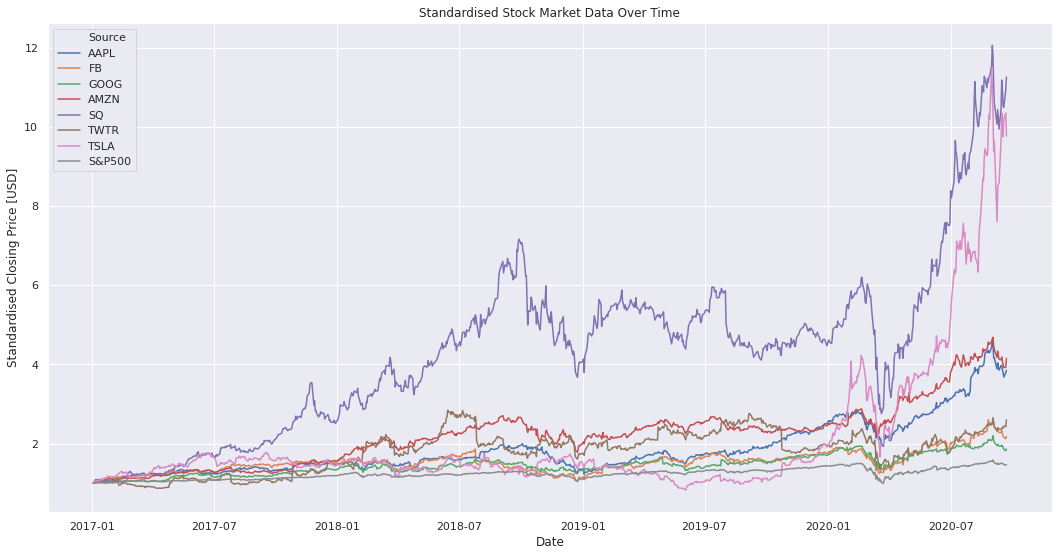

In [112]:
ax2 = sns.lineplot(x="Date",
                  y="Standardised_Closed",
                  hue = 'Source', data=source_data_df)
ax2.set_title('Standardised Stock Market Data Over Time')
ax2.set_ylabel('Standardised Closing Price [USD]')

Ahora, graficaremos ambas gráficas para hacer la comparación


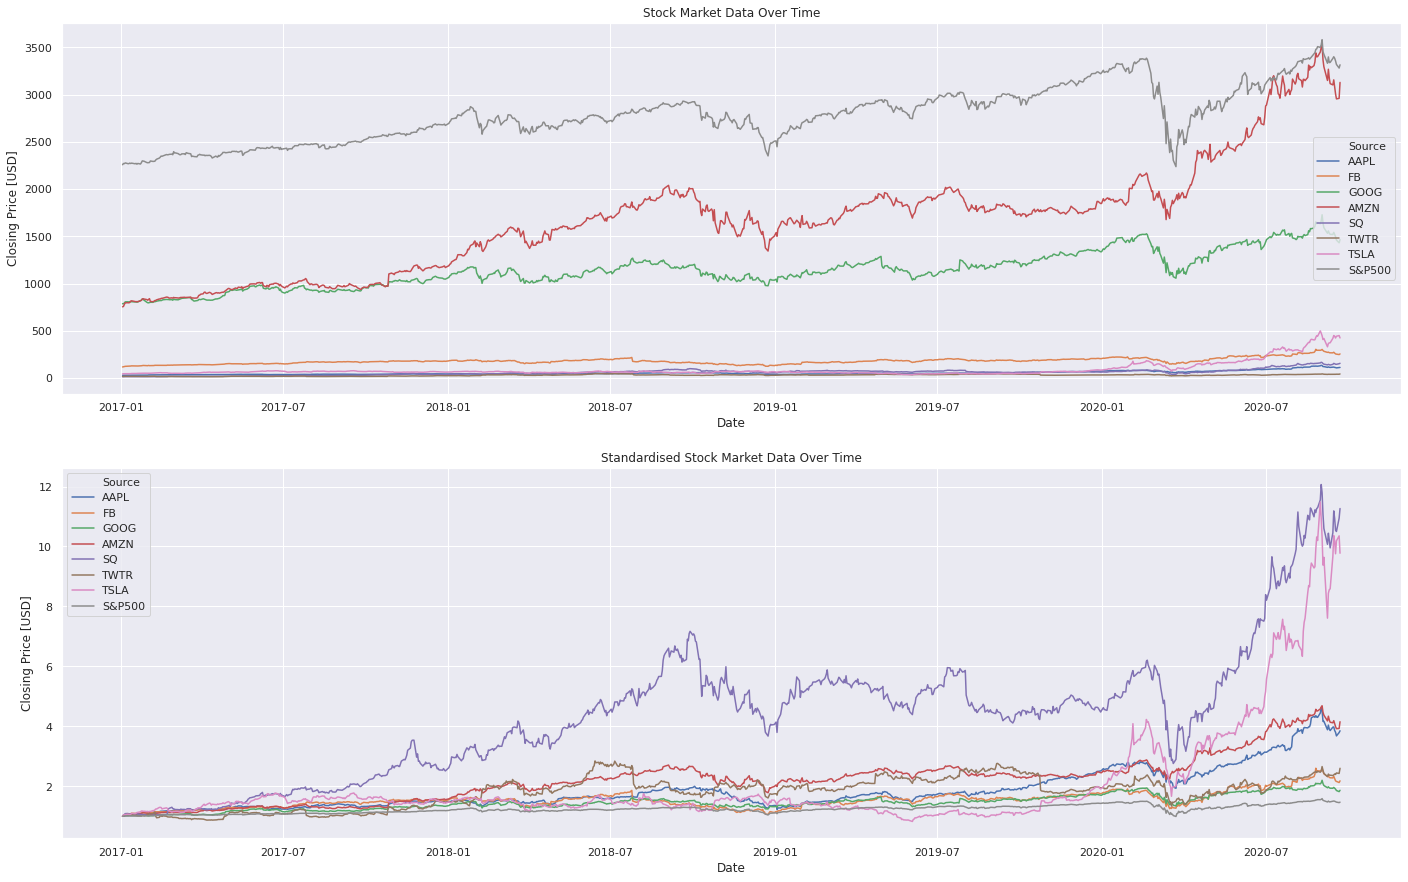

In [113]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(24,15))

sns.set_style("darkgrid")
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

ax1 = sns.lineplot(x="Date",
                  y="Close",
                  hue = 'Source', data=source_data_df,
                   ax=axs[0])
ax1.set_title('Stock Market Data Over Time')
ax1.set_ylabel('Closing Price [USD]')

ax2 = sns.lineplot(x="Date",
                  y="Standardised_Closed",
                  hue = 'Source', data=source_data_df, ax=axs[1])
                  
ax2.set_title('Standardised Stock Market Data Over Time')
ax2.set_ylabel('Closing Price [USD]')

plt.show()

Notas:


* Vemos que en valor absoluto el S&P500 tiene el precio más alto (por poco gana Amazon)
* Sin embargo, el análisis estandarizado muestra qué acciones han tenido mejor desempeño desde 2017.
* Por ejemplo, el precio al cuadrado de los componentes ha incrementado por un factor de 12 desde 2017, que comparado con el  ~4 del precio de Amazon.


## Retorno sobre inversión

In [114]:
stocks_lst = list(source_data_df.Source.unique())

for stock in stocks_lst: 
  print(
      str(stock) + ' Percentage Increase [%]: ', 
      str(
          round(
              (source_data_df[source_data_df.Source == stock]['Standardised_Closed']
               .loc[source_data_df[source_data_df.Source == stock]['Date'].idxmax()] - 1
               ) * 100
                , 2
                )
          )
      )

AAPL Percentage Increase [%]:  285.05
FB Percentage Increase [%]:  118.0
GOOG Percentage Increase [%]:  86.41
AMZN Percentage Increase [%]:  315.17
SQ Percentage Increase [%]:  1026.65
TWTR Percentage Increase [%]:  159.91
TSLA Percentage Increase [%]:  877.53
S&P500 Percentage Increase [%]:  46.85


Se muestra lo siguiente:


*   El precio DE SQ incrementó en 1026%
*   El S&P500 incrementó 46% desde 2017.



**Si invirtiéramos $10,000 en cada acción desde Enero 2017 ¿Cuánto valdría hoy?**

El siguiente código muestra qué pasaría si invirtiéramos $10,000 USD en cada acción: 
*   Tendríamos USD 371,600 de los originales USD 80,000 
*   La ganancia más grande fue de la acción SQ.
* La menor ganancia vino de S&P500.
* Es importante ver que el riesgo asociado con el SP&500 es menor que el de las otras acciones.



In [115]:
stocks_lst = list(source_data_df.Source.unique())

cum_sum = 0
for stock in stocks_lst: 
  result = round(
              (source_data_df[source_data_df.Source == stock]['Standardised_Closed']
               .loc[source_data_df[source_data_df.Source == stock]['Date'].idxmax()]
               )
                , 2
                )*10000
  cum_sum += result

  print(
      str(stock) + ' Percentage Increase [%]: ', 
      str(result)
      )
  
print('Cumulative Return = ' + str(cum_sum))

AAPL Percentage Increase [%]:  38500.0
FB Percentage Increase [%]:  21800.0
GOOG Percentage Increase [%]:  18600.0
AMZN Percentage Increase [%]:  41500.0
SQ Percentage Increase [%]:  112700.0
TWTR Percentage Increase [%]:  26000.0
TSLA Percentage Increase [%]:  97800.0
S&P500 Percentage Increase [%]:  14700.0
Cumulative Return = 371600.0


## Cambios en volúmenes de transacción

In [116]:
SQ_data_df = source_data_df[source_data_df.Source == 'SQ']

In [117]:
SQ_data_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Source,Standardised_Closed
3748,2017-01-03,14.015,13.660,13.82,13.81,3363900.0,13.81,SQ,1.000000
3749,2017-01-04,14.260,13.725,13.86,14.25,4977400.0,14.25,SQ,1.031861
3750,2017-01-05,14.610,14.010,14.25,14.56,5779800.0,14.56,SQ,1.054308
3751,2017-01-06,15.075,14.530,14.56,15.00,6382200.0,15.00,SQ,1.086169
3752,2017-01-09,15.195,14.850,14.98,15.06,4960200.0,15.06,SQ,1.090514


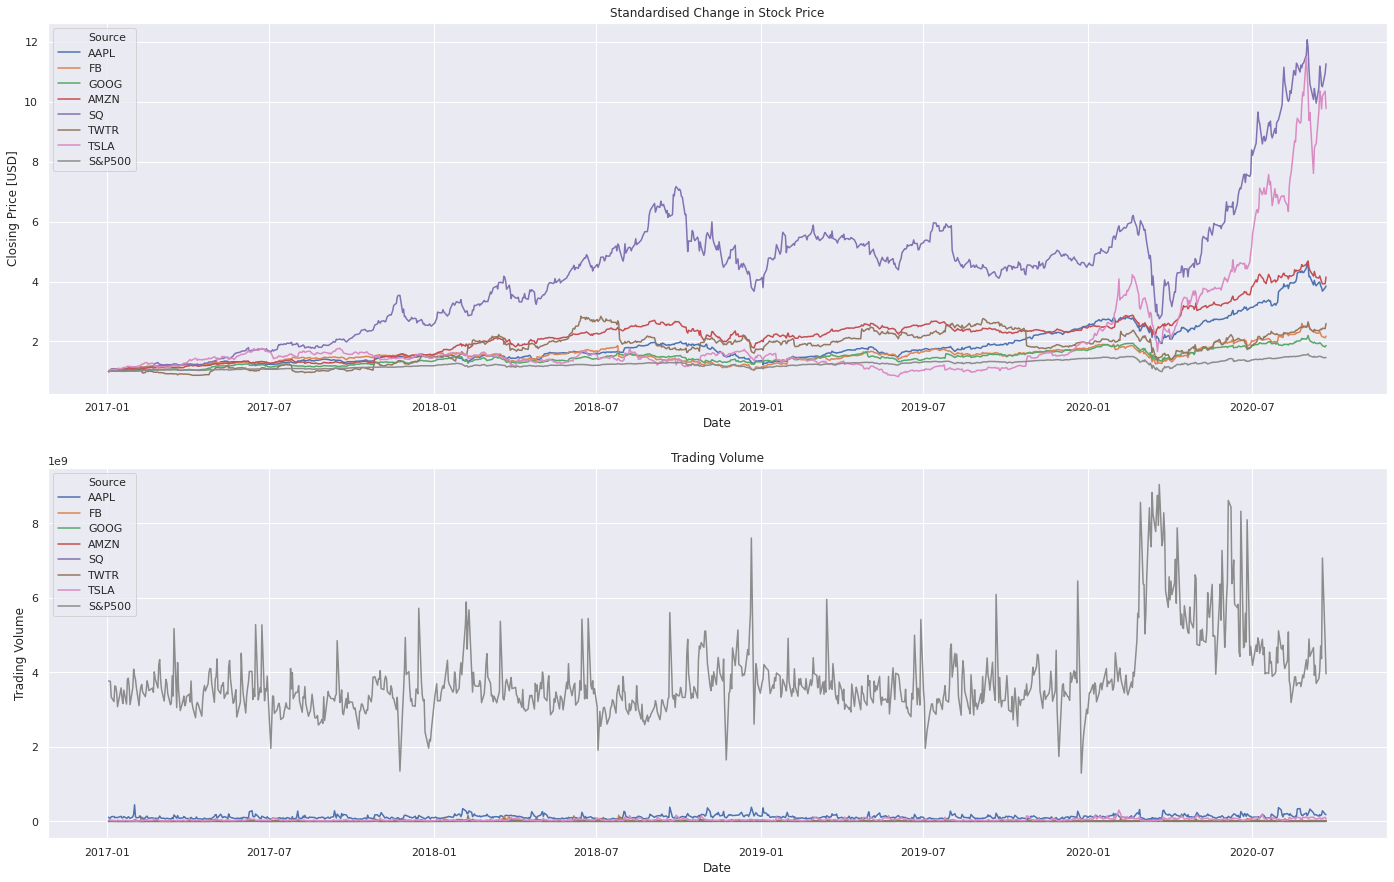

In [118]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(24,15))

sns.set_style("darkgrid")
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

ax1 = sns.lineplot(x="Date",
                  y="Standardised_Closed",
                  hue = 'Source', data=source_data_df,
                   ax=axs[0])
ax1.set_title('Standardised Change in Stock Price')
ax1.set_ylabel('Closing Price [USD]')

ax2 = sns.lineplot(x="Date",
                  y="Volume",
                  hue = 'Source', data=source_data_df, ax=axs[1])
                  
ax2.set_title('Trading Volume')
ax2.set_ylabel('Trading Volume')

plt.show()

Se muestra que el volúmen de transacciones de S&P500 es mucho mayor que el de las otras acciones

In [119]:
grouped = source_data_df.groupby(['Source']).Volume.median().reset_index()
grouped.sort_values('Volume', ascending=False)

,Source,Volume
4,S&P500,3.560430e+09
0,AAPL,1.106864e+08
6,TSLA,3.741650e+07
2,FB,1.742020e+07
7,TWTR,1.639950e+07
5,SQ,9.559500e+06
1,AMZN,3.862600e+06
3,GOOG,1.444300e+06


- Se muestra que el S&P500 es la más transaccionada y  Google la menos.

(-100.0, 50000000.0)

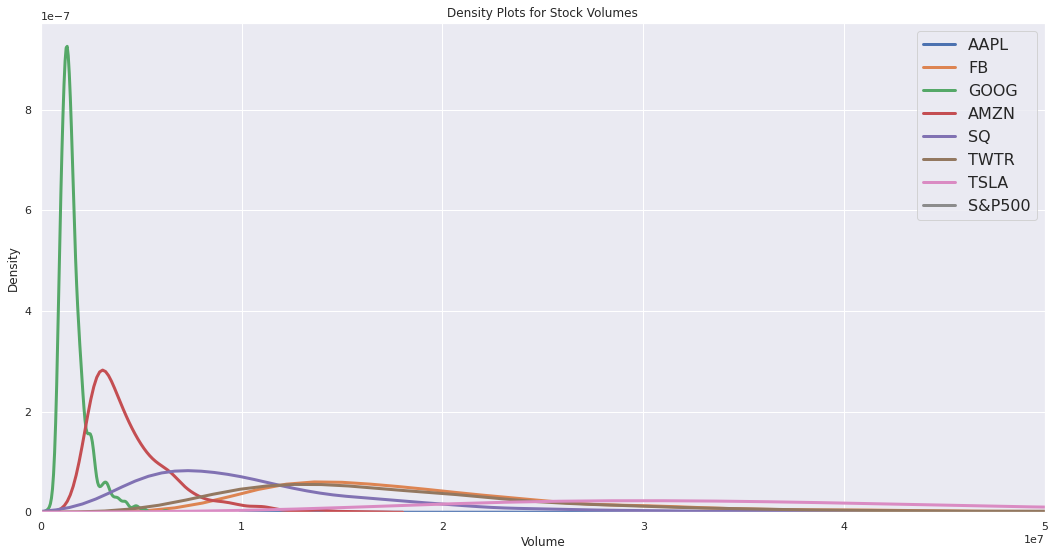

In [120]:
# List of the stocks
stocks_lst = list(source_data_df.Source.unique())

# Iterate through the stocks
for stock in stocks_lst:
    # Subset to the stock
    subset = source_data_df[source_data_df['Source'] == stock]
    
    # Draw the density plot
    sns.distplot(subset['Volume'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = stock)
    
# Plot formatting
plt.legend(prop={'size': 16})
plt.title('Density Plots for Stock Volumes')
plt.xlabel('Volume')
plt.ylabel('Density')
plt.xlim(left = -100,right = 50000000)

- The above data shows that Google is the least traded stock on the market over the past 2.5 years

# Correlación con S&P500 por cada acción

**Notas:**


*   El S&P500 representa una métrica diversificada de un portafolio de acciones del mercado de EUA.
* Si asumimos que S&P500 representa el comportamiento nos preguntamos lo siguiente:
  - ¿Qué tan dependiente es el desempeño de cada porcentaje de peso de cada acción sobre todo el mercado?
* Se escogió la R de Pearson
* Los resultados revelan que:
  - Tesla es el menos correlacionado con el S&P500
  - Google es el mas correlacionado, con R2 de 0.95




In [121]:
for stock in stocks_lst:

  c,p = stats.pearsonr(source_data_df[source_data_df.Source == 'S&P500']['Standardised_Closed'],
                       source_data_df[source_data_df.Source == stock]['Standardised_Closed'])
  print(stock + f" vs S&P500 Pearson Correlation: {round(c,2)}. And p-value: {p}\n")

AAPL vs S&P500 Pearson Correlation: 0.85. And p-value: 1.2576643634363865e-260

FB vs S&P500 Pearson Correlation: 0.85. And p-value: 4.003580607734158e-264

GOOG vs S&P500 Pearson Correlation: 0.95. And p-value: 0.0

AMZN vs S&P500 Pearson Correlation: 0.86. And p-value: 1.883450421827514e-269

SQ vs S&P500 Pearson Correlation: 0.86. And p-value: 5.365419797607241e-269

TWTR vs S&P500 Pearson Correlation: 0.73. And p-value: 9.088285183215798e-158

TSLA vs S&P500 Pearson Correlation: 0.58. And p-value: 6.990733250547729e-87

S&P500 vs S&P500 Pearson Correlation: 1.0. And p-value: 0.0



In [122]:
def correlation_plot(data_to_plot, stock, num):
  sns.set_style("darkgrid")
  font = {'family' : 'normal',
          'weight' : 'normal',
          'size'   : 18}
  matplotlib.rc('font', **font)

  r2 = round(stats.pearsonr(x=data_to_plot['S&P500'],
                      y=data_to_plot[stock])[0],
             3)

  ax = sns.regplot(x='S&P500',
            y=stock,
            data = data_to_plot,
            line_kws={'color': 'red'},
            ci=0.05,
            ax=num)

  # Plot formatting
  ax.set_title(f'{stock} Vs S&P500 - $R^2$  = {r2}')
  ax.set_xlabel('Standardized Closing Price for S&P500')
  ax.set_ylabel('Standardized Closing Price for ' + stock)

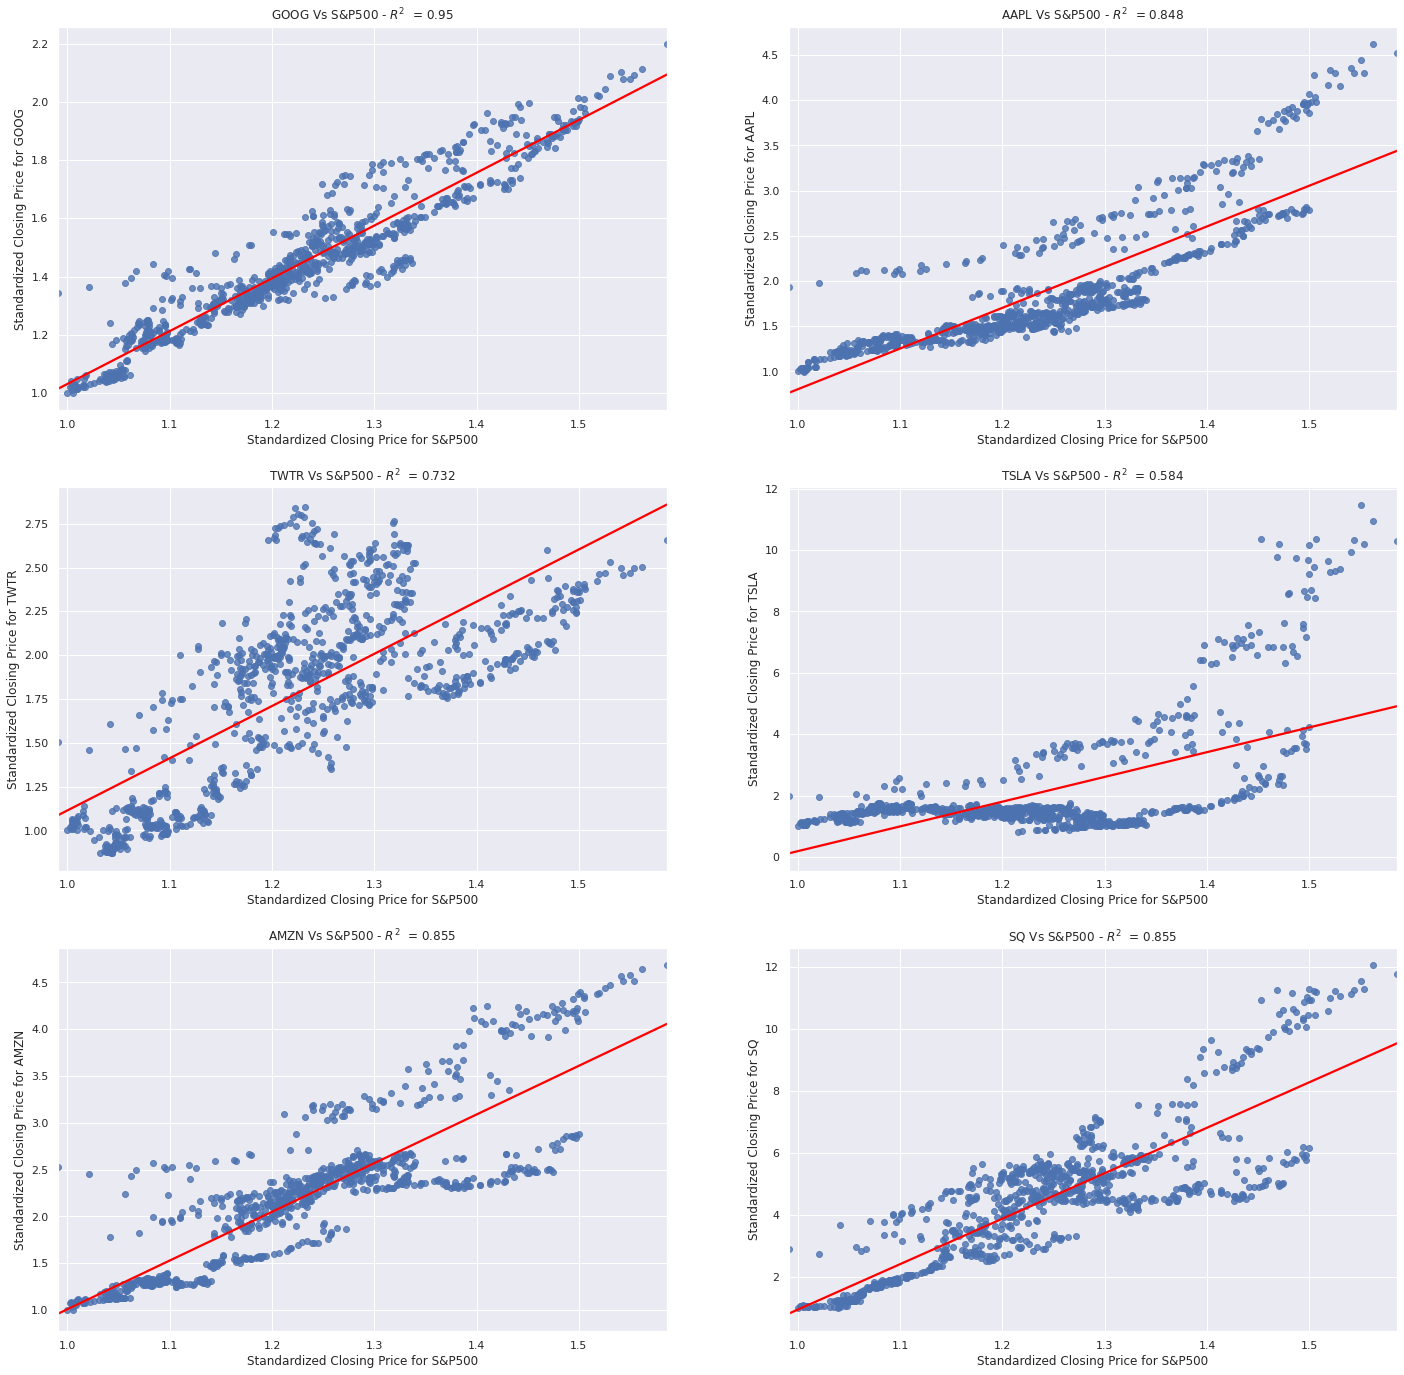

In [123]:
pivotTableDF = pd.pivot_table(source_data_df,
                                index='Source',
                                columns='Date',
                                values='Standardised_Closed',
                                margins=False)

data_to_plot = pivotTableDF.transpose()

fig, ([ax1, ax2],
      [ax3, ax4],
      [ax5, ax6]) = plt.subplots(nrows=3,
                                 ncols=2,
                                 figsize=(24,24),
                                 sharey=False)
correlation_plot(data_to_plot, 'GOOG', ax1)
correlation_plot(data_to_plot, 'AAPL', ax2)
correlation_plot(data_to_plot, 'TWTR', ax3)
correlation_plot(data_to_plot, 'TSLA', ax4)
correlation_plot(data_to_plot, 'AMZN', ax5)
correlation_plot(data_to_plot, 'SQ', ax6)
plt.show()

# Construyendo el modelo predictivo

- Construiremos el modelo para predecir el precio del día siguiente usando datos de apertura y cierre.
- Utilizaremos Keras

In [124]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
#from keras.layers import CuDNNLSTM
from keras.layers import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import tensorflow as tf
from keras.callbacks import *

Usaremos datos de hoy y apertura del día siguiente para predecir el precio de cierre

In [125]:
def get_stock_data(stock_name, start, end, normalize=True):
    df = web.DataReader(stock_name, "yahoo", start, end)
    print ("origina data\n")
    print (df.head(10))
    
    df.drop(['Close'], 1, inplace=True)
    df['Volume'] = df['Volume'].astype(float)
    df = df[['Open','Volume','High','Low','Adj Close']]

    if normalize:        
        price_scaler = preprocessing.MinMaxScaler()
        price_scaler.fit(df['Open'].values.reshape(-1,1))
        volume_scaler = preprocessing.MinMaxScaler()
        volume_scaler.fit(df['Volume'].values.reshape(-1,1))
        df['Open'] = price_scaler.transform(df.Open.values.reshape(-1,1))
        df['High'] = price_scaler.transform(df.High.values.reshape(-1,1))
        df['Low'] = price_scaler.transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = price_scaler.transform(df['Adj Close'].values.reshape(-1,1))
        df['Volume'] = volume_scaler.transform(df['Volume'].values.reshape(-1,1))
    return df, price_scaler, volume_scaler


def load_data(df, seq_len):
    amount_of_features = len(df.columns)
    data = df.to_numpy()  # convert dataframe to np array
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = int(round(0.9 * result.shape[0])) # 90% split
    
    # training data
    train = result[:row, :] # first 90% date
    X_train = train[:, :-1] # all data until day m

    y_train = train[:, -1][:,-1] # day m + 1 
    
    # testing data
    test = result[row:, :]
    X_test = test[:, :-1]

    y_test = test[:, -1][:,-1]  # day m + 1 
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

## Tomar los datos

In [126]:
stock_name = 'MSFT'
start = datetime.date(1990, 1, 1)
end = datetime.date.today()
df, price_scaler, volume_scaler = get_stock_data(stock_name, start, end)

origina data

                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
1990-01-02  0.616319  0.598090  0.605903  0.616319   53033600.0   0.393385
1990-01-03  0.626736  0.614583  0.621528  0.619792  113772800.0   0.395601
1990-01-04  0.638889  0.616319  0.619792  0.638021  125740800.0   0.407236
1990-01-05  0.638889  0.621528  0.635417  0.622396   69564800.0   0.397263
1990-01-08  0.631944  0.614583  0.621528  0.631944   58982400.0   0.403358
1990-01-09  0.638889  0.626736  0.631944  0.630208   70300800.0   0.402250
1990-01-10  0.633681  0.611979  0.625000  0.612847  103766400.0   0.391168
1990-01-11  0.621528  0.590278  0.616319  0.600694   95772800.0   0.383411
1990-01-12  0.605903  0.583333  0.591146  0.598090  148908800.0   0.381749
1990-01-15  0.604167  0.592014  0.595486  0.598090   62467200.0   0.381749


In [127]:
df.tail(10)

,Open,Volume,High,Low,Adj Close
Date,,,,,
2020-09-09,0.905238,0.055170,0.936898,0.901303,0.921374
2020-09-10,0.930601,0.041740,0.936461,0.889977,0.895487
2020-09-11,0.903489,0.039320,0.909742,0.877426,0.889627
2020-09-14,0.890545,0.035056,0.912235,0.889627,0.895662
2020-09-15,0.908824,0.023815,0.914771,0.902308,0.910398
2020-09-16,0.918445,0.029735,0.918576,0.892294,0.894087
2020-09-17,0.872223,0.039834,0.890939,0.871829,0.884729
2020-09-18,0.884248,0.067718,0.887965,0.855605,0.873709
2020-09-21,0.859716,0.047495,0.883855,0.856174,0.883111


In [147]:
seq_len =  5#@param

X_train, y_train, X_test, y_test = load_data(df,seq_len)

In [129]:
print (X_train.shape) #Number of rows in training dataset, number of historical instances to account for, number of features
print (X_test.shape) #Number of rows in testing dataset, number of historical instances to account for, number of features

(6964, 3, 5)
(774, 3, 5)


In [148]:
print (y_train.shape)
print (y_test.shape)

(6962,)
(774,)


### Por hacer: Agregar más variables

In [149]:
print (df.count())

Open         7742
Volume       7742
High         7742
Low          7742
Adj Close    7742
dtype: int64


In [150]:
df.tail()


,Open,Volume,High,Low,Adj Close
Date,,,,,
2020-09-16,0.918445,0.029735,0.918576,0.892294,0.894087
2020-09-17,0.872223,0.039834,0.890939,0.871829,0.884729
2020-09-18,0.884248,0.067718,0.887965,0.855605,0.873709
2020-09-21,0.859716,0.047495,0.883855,0.856174,0.883111
2020-09-22,0.894131,0.039068,0.907425,0.881100,0.904451


In [151]:
X_test

array([[[0.31917623, 0.02533115, 0.32044439, 0.31401615, 0.30015339],
        [0.31344765, 0.01978961, 0.31594023, 0.31196086, 0.30052969],
        [0.31432226, 0.0184401 , 0.314366  , 0.31095507, 0.29910803],
        [0.31379749, 0.01398281, 0.31768941, 0.31379749, 0.30333135],
        [0.31646499, 0.01322413, 0.31729586, 0.31458463, 0.30149155]],

       [[0.31344765, 0.01978961, 0.31594023, 0.31196086, 0.30052969],
        [0.31432226, 0.0184401 , 0.314366  , 0.31095507, 0.29910803],
        [0.31379749, 0.01398281, 0.31768941, 0.31379749, 0.30333135],
        [0.31646499, 0.01322413, 0.31729586, 0.31458463, 0.30149155],
        [0.31550294, 0.01760348, 0.3160277 , 0.31257307, 0.30136604]],

       [[0.31432226, 0.0184401 , 0.314366  , 0.31095507, 0.29910803],
        [0.31379749, 0.01398281, 0.31768941, 0.31379749, 0.30333135],
        [0.31646499, 0.01322413, 0.31729586, 0.31458463, 0.30149155],
        [0.31550294, 0.01760348, 0.3160277 , 0.31257307, 0.30136604],
        [0.31602

Plot out the Normalized Adjusted close price and Return

In [152]:
def plot_close_price(df):
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

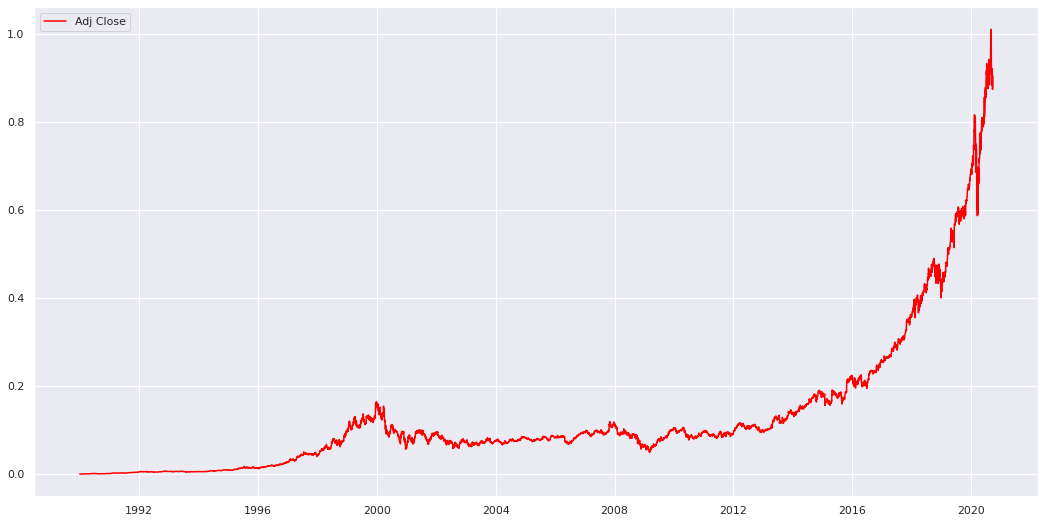

In [153]:
try:
    plot_close_price(df)
except:
    pass

## Parte 1: Crear el modelo LSTM RNN

###Arquitectura

Ligas: 

*   To the Keras Guide to implementation a Sequential Model: [Click Here](https://keras.io/getting-started/sequential-model-guide/)
*   To the Keras documentation on LSTM is [here](https://keras.io/layers/recurrent/#lstm)




In [154]:
def build_model_base(input_shape, neurons, dropout, lr_decay = 0.9, loadmodelFilepath= None):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(input_shape[0], input_shape[1]), return_sequences=True))
    model.add(Dropout(dropout))
        
    model.add(LSTM(neurons[1], input_shape=(input_shape[0], input_shape[1]), return_sequences=False))
    model.add(Dropout(dropout))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    if loadmodelFilepath:
        try:
            model = load_model(loadmodelFilepath)
        except:
            pass
    
    adam = keras.optimizers.Adam(lr= 0.01, decay=lr_decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Ejecución del modelo

In [155]:
callbacks = []

## Parámetros

In [156]:
print(X_train.shape[0]) # Number of Training Examples
print(X_train.shape[1]) # This is the sequence to consider (set as an input)
print(X_train.shape[2]) # 5 features for each input

6962
5
5


In [157]:
# Parameters : dropout, neurons, epochs, learning rate decay, epochs, seq_len

dropout = 0.1
neurons = [128, 129, 32, 1]
epochs = 300

shape = [X_train.shape[1], X_train.shape[2]] 
model = build_model_base(shape, neurons, dropout, lr_decay=0.7)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 128)            68608     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 129)               133128    
_________________________________________________________________
dropout_5 (Dropout)          (None, 129)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 205,929
Trainable params: 205,929
Non-trainable params: 0
________________________________________________

## Entrenamiento

In [158]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    callbacks = callbacks,
    validation_split=0.1,
    verbose=2)

Epoch 1/300
13/13 - 1s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0267 - val_accuracy: 0.0000e+00
Epoch 2/300
13/13 - 0s - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 0.0172 - val_accuracy: 0.0000e+00
Epoch 3/300
13/13 - 0s - loss: 8.7821e-04 - accuracy: 0.0000e+00 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 4/300
13/13 - 0s - loss: 2.7947e-04 - accuracy: 0.0000e+00 - val_loss: 8.7531e-04 - val_accuracy: 0.0000e+00
Epoch 5/300
13/13 - 0s - loss: 1.1127e-04 - accuracy: 0.0000e+00 - val_loss: 1.7387e-04 - val_accuracy: 0.0000e+00
Epoch 6/300
13/13 - 0s - loss: 9.3880e-05 - accuracy: 0.0000e+00 - val_loss: 9.0352e-04 - val_accuracy: 0.0000e+00
Epoch 7/300
13/13 - 0s - loss: 7.7112e-05 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 8/300
13/13 - 0s - loss: 7.3705e-05 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 9/300
13/13 - 0s - loss: 7.1028e-05 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+

## Entrenamiento pérdida y valor de pérdida por época

In [159]:
def plotTrainTestLoss(history):
    assert isinstance(history, keras.callbacks.History), "input must be a keras.callbacks.History instance"
    train_metrics = history.history
    plt.close('all')
    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(train_metrics['loss'], color='blue', label='train_loss')
    ax1.legend(loc='best')
    
    ax2.plot(train_metrics['val_loss'], color='red', label='val_loss')
    ax2.legend(loc='best')
    f.subplots_adjust(hspace=0.1)
    plt.xlabel("Epochs")
    plt.show()

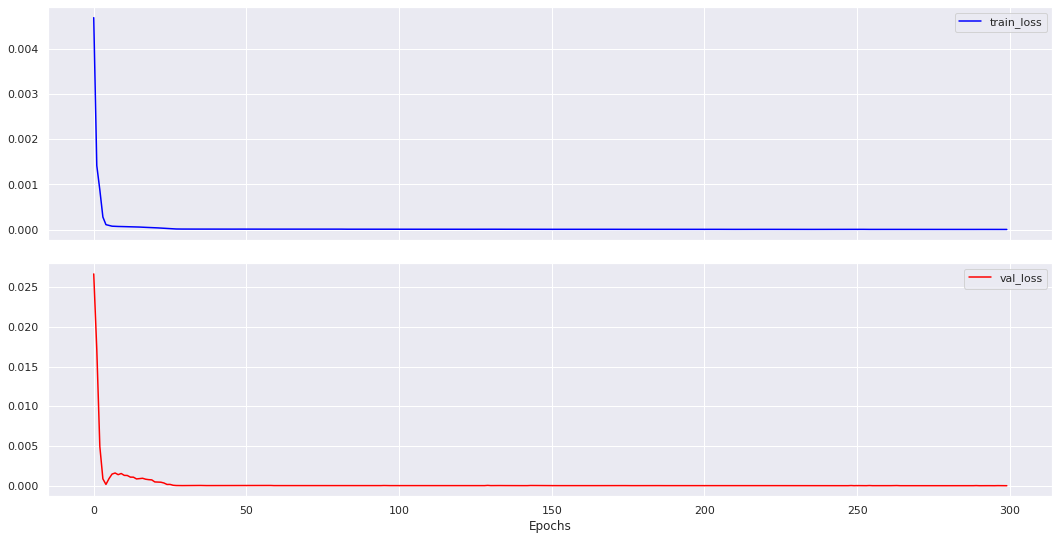

In [160]:
plotTrainTestLoss(history)

## Resultados sobre el conjunto de entrenamiento y pruebas

In [161]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [162]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00000 MSE (0.00218 RMSE)
Test Score: 0.00017 MSE (0.01292 RMSE)


(4.761940544995014e-06, 0.00016690499614924192)

## Predicción vs. Valores Reales

In [163]:
def getPrediction(model, X_test, y_test, price_scaler=None, denormalize=False):
    p = model.predict(X_test)
    price = None
    if denormalize and price_scaler:
        price = price_scaler.inverse_transform(p)
    
    return p, price

def plot_result(stock_name, normalized_p, normalized_value_y_test):
    plt.plot(normalized_p, color='red', label='Prediction')
    plt.plot(normalized_value_y_test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The test result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Adjusted Close')
    plt.show()
    
def plotTrainFitAndTestPrediction(model, X_train, y_train, X_test, y_test):
    p, _ = getPrediction(model, X_test, y_test)
    plot_result(stock_name, p, y_test)
    train_p, _ = getPrediction(model, X_train, y_train)
    plot_result(stock_name, train_p, y_train)

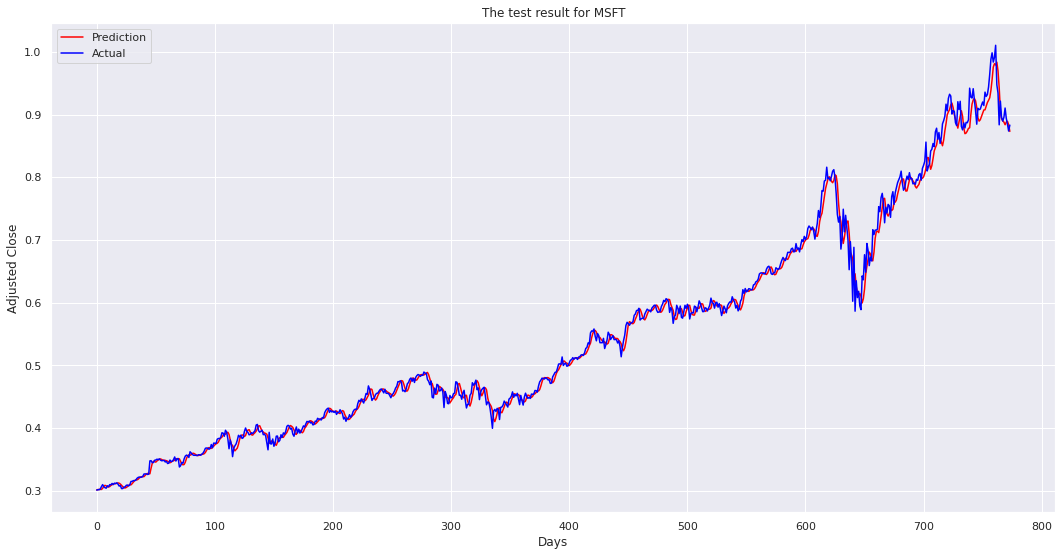

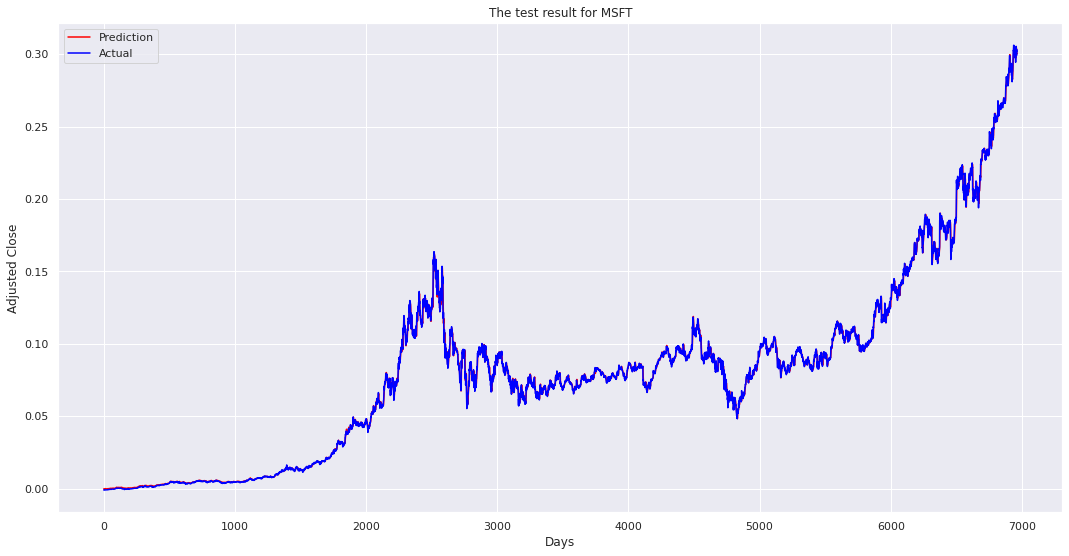

In [164]:
plotTrainFitAndTestPrediction(model, X_train, y_train, X_test, y_test)